### Import the packages

In [1]:
import sagemaker
import sys

sys.path.append("src")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

Get sagemaker Session and set the output bucket to store intermediate checkpoints and models

In [3]:
sage_session = sagemaker.session.Session()
s3_bucket="thejan-sagemaker-101"
s3_output_path = "s3://{}/".format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://thejan-sagemaker-101/


In [4]:
# create a descriptive job name
job_name_prefix = "rl-lunar-lander-ray"

Whether want to run the in the notebook instance or in a separate instance. 

In [5]:
instance_type = "ml.m4.xlarge"

In [6]:
train_instance_count = 1

In [7]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Couldn't call 'get_role' to get Role ARN from role name trajapakshe to get Role path.


Using IAM role arn: arn:aws:iam::673765577618:role/sagemaker


### Schedule the training.
Using a custom built docker image to train, since pre-build docker image `sagemaker-rl-tensorflow:coach0.11.1-cpu-py3` does not contain `gym[box2d]` packages.

In [8]:
training_image = "673765577618.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-rl-ray-container:ray-1.6.0-gym-box2d-tf-cpu-py37"

In [12]:
%%time

metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)

estimator = RLEstimator(
    entry_point="train-rl-lunarlander-ray.py",
    source_dir="src",
    dependencies=["src/sagemaker_rl"],
    role=role,
    debugger_hook_config=False,
    instance_type=instance_type,
    instance_count=train_instance_count,
    output_path=s3_output_path,
    base_job_name=job_name_prefix,
    metric_definitions=metric_definitions,
    image_uri=training_image,
    hyperparameters={
        "rl.training.config.dueling": True
    },
)


CPU times: user 109 ms, sys: 45.1 ms, total: 154 ms
Wall time: 176 ms


In [ ]:
estimator.fit()
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

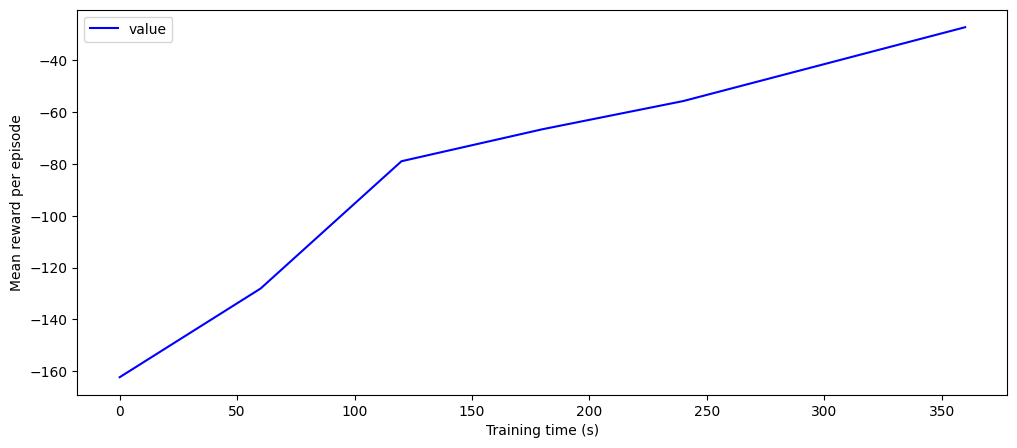

In [11]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

df = TrainingJobAnalytics(job_name, ["episode_reward_mean"]).dataframe()
num_metrics = len(df)
if num_metrics == 0:
    print("No algorithm metrics found in CloudWatch")
else:
    plt = df.plot(x="timestamp", y="value", figsize=(12, 5), legend=True, style="b-")
    plt.set_ylabel("Mean reward per episode")
    plt.set_xlabel("Training time (s)")

## Parameter Tuning


In [10]:
# Pick the total number of training jobs to run in this tuning job
max_jobs = 5

# How many jobs should run at a time.  Higher numbers here mean the tuning job runs much faster,
# while lower numbers can sometimes get better results
max_parallel_jobs = 5

from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# The hyperparameters we're going to tune
hyperparameter_ranges = {
    "rl.training.config.num_sgd_iter": IntegerParameter(3, 10),
     "rl.training.config.gamma": ContinuousParameter(0.995, 1.0)
}

# The hyperparameters that are the same for all jobs
static_hyperparameters = {
    "rl.training.stop.time_total_s": 600,  # Tell each training job to stop after 10 minutes
}

In [13]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="episode_reward_mean",
    objective_type="Maximize",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    base_tuning_job_name=job_name_prefix,
)
tuner.fit(wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
